In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widjets

import os
import time
import json
import glob
from tqdm import tqdm
from sys import getsizeof

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

from skimage.io import imread
import matplotlib.pyplot as plt
from PIL import Image, ImageChops
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
images_list = []
for filename in glob.glob('Task/images/*.jpg'):
    im=Image.open(filename)
    images_list.append(im)
print(len(images_list), 'images loaded')

points_list = []   # в формате [x,y]
for filename in glob.glob('Task/points/*.txt'): #assuming gif
    a=np.loadtxt(filename,dtype=np.int32)
    points_list.append(a)
print(len(points_list), 'dots loaded')

def trim(im):
    bg = Image.new(im.mode, im.size, 255) #white pixel=255
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -30)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox), np.array(bbox[:2]) #returns x,y
    else:
        return im, (0,0)

for i in range(len(images_list)):
    images_list[i], coords = trim(images_list[i])
    points_list[i] -= coords
print('cropped')

4067 images loaded
4067 dots loaded
cropped


In [3]:
def orient_portrait_style(images_list,points_list):
    num_of_reverted = 0
    for i in range(len(images_list)):
        x,y = images_list[i].size
        if x>y:
            images_list[i] = Image.fromarray(np.asarray(images_list[i]).T)
            points_list[i] = np.roll(points_list[i],1,axis=1)
            num_of_reverted += 1
    print('reverted ', num_of_reverted, 'imgs')
            
orient_portrait_style(images_list,points_list)

reverted  33 imgs


In [4]:
#scale to y_new

_Y_new = 400
for i in range(len(images_list)):
    x_old, y_old = images_list[i].size
    images_list[i] = images_list[i].resize((int(x_old/y_old * _Y_new),_Y_new), resample=Image.BICUBIC)
    points_list[i] = (points_list[i] * _Y_new / y_old).astype(int)
print(f'resize done to y={_Y_new}')

resize done to y=400


In [5]:
#add white borders to img, to make x==y

_NEW_SIZE = (_Y_new, _Y_new) #т.к есть ~квадратные отпечатки
for i in range(len(images_list)):
    old_im = images_list[i]
    new_im = Image.new("L", _NEW_SIZE,255) # same as np.zeros, fill 255
    bias = (_NEW_SIZE[0] - old_im.size[0])//2
    new_im.paste(old_im, (bias,0)) #помещает в позицию x=bias,y=0
    images_list[i] = new_im
    points_list[i][:,0] += bias #x+bias
print(f'resize to {_NEW_SIZE} done')

resize to (400, 400) done


In [126]:
images_array = np.array([np.array(image) for image in images_list])

In [9]:
#look images with points
@interact(i=(0,len(images_list)-1,1))
def test_func(i=572):
    im = np.array(images_list[i])
    points = points_list[i]
    a=np.tile(im,(3,1,1))
    a=np.moveaxis(a, 0, -1)
    for point in points:
        x,y = point
        a[y-3:y+3,x-3:x+3] = np.array([255,0,0])
    print(im.shape)
    plt.figure(figsize=[10,10])
    plt.imshow(a)

interactive(children=(IntSlider(value=572, description='i', max=4066), Output()), _dom_classes=('widget-intera…

In [10]:
#find max res (чтобы не растягивать не изменять ratio)

x_max,y_max = 0,0
x_sum,y_sum = 0,0
x_max_i,y_max_i = 0,0
for i in range(len(images_list)):
    y,x = np.array(images_list[i]).shape
    x_sum += x
    y_sum += y
    if x>x_max: 
        x_max = x
        x_max_i = i
    if y>y_max:
        y_max = y
        y_max_i = i
print('maximum x,y = ',x_max,y_max)
print('max indexes', x_max_i,y_max_i)
print('mean values',x_sum/len(images_list),y_sum/len(images_list))

maximum x,y =  400 400
max indexes 0 0
mean values 400.0 400.0


In [6]:
x, y = np.mgrid[0:1.0:25j, 0:1.0:25j]
xy = np.column_stack([x.flat, y.flat])
mask = np.zeros(25 * 25)
COV=np.diag([0.03,0.03])
Mean=[0.5,0.5]
Gauss = multivariate_normal.pdf(xy, mean=Mean, cov=COV)
Gauss *= np.sqrt(np.linalg.det(COV)*(2*np.pi)**2)  #normalize to 1(formulae Gauss)
Gauss = Gauss.reshape((25, 25))

def Get_mask(points):
    global Gauss
    mask = np.zeros((400,400))
    for point in points:
        x,y = point
        part_of_mask = mask[y-12:y+13,x-12:x+13]
        _y, _x = part_of_mask.shape
        indexes = part_of_mask < Gauss[:_y,:_x]
        part_of_mask[indexes] = Gauss[:_y,:_x][indexes]
    return mask


In [16]:
@interact(i=(0,len(images_list),1))
def test_func(i=24):
    img = images_list[i]
    mask = Get_mask(points_list[i])
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(mask)

interactive(children=(IntSlider(value=24, description='i', max=4067), Output()), _dom_classes=('widget-interac…

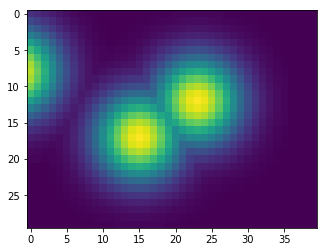

In [197]:
a = Get_mask(points_list[0])
plt.imshow(a[170:200,100:140])

In [7]:
from albumentations import Compose, RandomRotate90, Flip, Transpose, ShiftScaleRotate
def strong_aug(p=0.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5,border_mode=0,value=255),
    ], p=p)

class Images_Loader(torch.utils.data.Dataset):
    def __init__(self,_images,_points):
        super(Images_Loader, self).__init__()
        self._images, self._points = _images, _points
        self.transform = transforms.ToTensor()
        
    def __len__(self):
        return len(self._images)
    
    def __getitem__(self, i):
        _image = np.asarray(self._images[i])
        _mask = Get_mask(self._points[i])
        augmentation = strong_aug(p=0.9)
        
        data = {"image": _image, "mask": _mask}
        augmented = augmentation(**data)
        _image, _mask = self.transform(augmented["image"]), self.transform(augmented["mask"]).float()

        return [_image, _mask]

#Грузим датку, ставим размер картинок         !!!!!!!! добавить аугментацию !!!!!!!!!

num_val = 10

train_dataset = Images_Loader(images_list[:-num_val], points_list[:-num_val])
val_dataset = Images_Loader(images_list[-num_val:], points_list[-num_val:])

batch_size = 5

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
}



In [9]:
# описание сети
def dice_loss(pred, target, eps = 1e-10):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + eps) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + eps)))
    
    return loss.mean()

def calc_loss(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    return loss

def _double_conv(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )


def _down(in_ch, out_ch):
    return nn.Sequential(
        nn.MaxPool2d(2),
        _double_conv(in_ch, out_ch)
    )


def _up(in_ch, out_ch):
    return nn.Sequential(
        _double_conv(in_ch, in_ch//2),
        nn.ConvTranspose2d(in_ch//2, out_ch, 2, stride=2)  
    )
    

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down0 = _double_conv(1, 64)
        self.down1 = _down(64, 128)
        self.down2 = _down(128, 256)
        self.down3 = _down(256, 512)
        self.down4 = _down(512, 1024)

        self.up0 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.up1 = _up(1024,256)
        self.up2 = _up(512,128)
        self.up3 = _up(256,64)
        self.up4 = _double_conv(128, 64)
        
        self.conv_last = nn.Sequential(
            nn.Conv2d(64, 1, 1), #in_channels, out_channels, kernel_size
            nn.Sigmoid()
        )
        
        
    def forward(self, X):
        down0 = self.down0(X)       #64
        down1 = self.down1(down0)   #128
        down2 = self.down2(down1)   #256
        down3 = self.down3(down2)   #512
        down4 = self.down4(down3)   #1024
        
        out = self.up0(down4)    #512
        out = self.up1(torch.cat([out, down3], dim=1))
        out = self.up2(torch.cat([out, down2], dim=1))
        out = self.up3(torch.cat([out, down1], dim=1))    
        out = self.up4(torch.cat([out, down0], dim=1))       #64
        
        out = self.conv_last(out)   #n_class
        
        return out
    


In [3]:
from torchsummary import summary
model = UNet().cuda()
summary(model, input_size=(1,400,400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]             640
       BatchNorm2d-2         [-1, 64, 400, 400]             128
              ReLU-3         [-1, 64, 400, 400]               0
            Conv2d-4         [-1, 64, 400, 400]          36,928
       BatchNorm2d-5         [-1, 64, 400, 400]             128
              ReLU-6         [-1, 64, 400, 400]               0
         MaxPool2d-7         [-1, 64, 200, 200]               0
            Conv2d-8        [-1, 128, 200, 200]          73,856
       BatchNorm2d-9        [-1, 128, 200, 200]             256
             ReLU-10        [-1, 128, 200, 200]               0
           Conv2d-11        [-1, 128, 200, 200]         147,584
      BatchNorm2d-12        [-1, 128, 200, 200]             256
             ReLU-13        [-1, 128, 200, 200]               0
        MaxPool2d-14        [-1, 128, 1

In [10]:
#грузим модель
model = UNet().cuda()
try:
    model.load_state_dict(torch.load('model_last.pt'))#, strict=False)
    print('weights loaded')
except:
    print('creating new NN')
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


weights loaded
cuda:0


In [13]:
#обучение
#optimizer = optim.SGD(model.parameters(),lr=0.1,momentum=0.9,weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.BCELoss()
num_epochs = 60

best_loss = 1
loss_list = []
for epoch in range(num_epochs):
    print('-' * 30)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 30)
    since = time.time()

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()

            #for inputs, true_outputs in tqdm(dataloaders[phase], total=len(dataloaders[phase])):
            for inputs, true_outputs in dataloaders[phase]:  
                inputs,true_outputs = inputs.cuda(),true_outputs.cuda()      
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    loss = criterion(outputs, true_outputs)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
        else:
            model.eval() 

            epoch_samples = 0
            epoch_loss = 0
            #for inputs, true_outputs in tqdm(dataloaders[phase], total=len(dataloaders[phase])):
            for inputs, true_outputs in dataloaders[phase]:
                inputs,true_outputs = inputs.cuda(),true_outputs.cuda()
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    loss = criterion(outputs, true_outputs)

                # statistics
                epoch_loss += loss.item()
                epoch_samples += 1
                    
            epoch_loss = epoch_loss/epoch_samples
            print(f'loss = {epoch_loss}')
            loss_list.append(epoch_loss)

        if phase == 'val' and epoch_loss < best_loss:
            print("saving best model")
            best_loss = epoch_loss
            torch.save(model.state_dict(), 'model_0.pt')

    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:4f}'.format(best_loss))

------------------------------
Epoch 0/59
------------------------------


KeyboardInterrupt: 

In [33]:
#torch.save(model.state_dict(), 'model_last.pt')

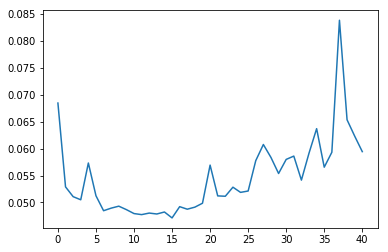

In [11]:
x = loss_list
plt.plot(x)

In [79]:
def get_predicted_points(image):
    img = image.copy()
    # https://stackoverflow.com/questions/46441893/connected-component-labeling-in-python
    img[img<img.max()-0.3] = 0
    img = (img/img.max()*255).astype(np.uint8)

    img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
    ret, labels = cv2.connectedComponents(img)
    predicted_points = []
    for i in range(1,ret+1):
        dots = np.argwhere(labels==i)
        N = dots.shape[0]
        if N>=4: #если  "кучка точек состоит из более чем 4 пикселей"
            coord = (dots.sum(axis=0)/N).astype(int)
            predicted_points.append(coord)
    return np.array(predicted_points)

In [183]:
def Get_predict(i):
    image_arr = np.array(images_list[i])
    inputs = image_arr.reshape(400,400,1,1).transpose(2,3,0,1)
    inputs = torch.from_numpy(inputs).float().cuda()

    true_mask = Get_mask(points_list[i])
    pred_mask = model(inputs).cpu().data.numpy()[0,0]

    points_pred = get_predicted_points(pred_mask) # Y, X (в датасете наоборот)
    return points_pred,true_mask,pred_mask

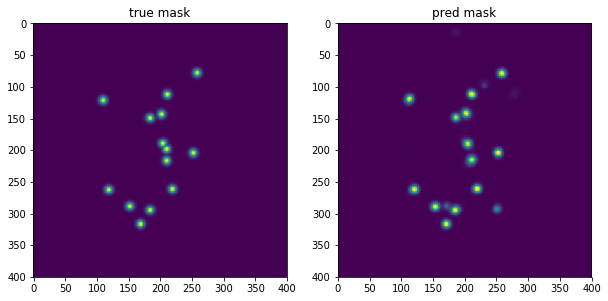

In [186]:
points_pred,true_mask,pred_mask = Get_predict(10)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('true mask')
plt.imshow(true_mask)
plt.subplot(1,2,2)
plt.title('pred mask')
plt.imshow(pred_mask)

plt.savefig('true_predicted.png')

In [192]:
#look images with points
@interact(i=(0,len(images_list)-1,1),pred_flag=(0,1,1), true_flag=(0,1,1))
def test_func(i=1,pred_flag=1,true_flag=1):
    points_pred, _, _ = Get_predict(i)
    
    img = np.array(images_list[i])
    points_true = points_list[i]
    
    a=np.tile(img,(3,1,1))
    a=np.moveaxis(a, 0, -1)
    if true_flag:
        for point in points_true:
            x,y = point
            a[y-4:y+5,x-4:x+5][:,:,0] = 255
    if pred_flag:
        for point in points_pred:
            y,x = point
            a[y-4:y+5,x-4:x+5][:,:,1] = 255
        
    print(img.shape)
    plt.figure(figsize=[10,10])
    plt.imshow(a)

interactive(children=(IntSlider(value=1, description='i', max=4066), IntSlider(value=1, description='pred_flag…